In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Abstract

This library is a sub-system of the algorithmic trading application. This library provides all the technical indicators. The indicators are provided by appending them to the original dataframe which holds the chart data.

# Functionality

The library supports the following technical indicators:

 * **Daily returns**: `daily_returns(df, source_column, target_column)`
 * **Simple moving average**: `sma(df, periods, source_column, target_column)` 
 * **Weighted moving average**: `wma(df, periods, source_column, target_column)` 
 * **Exponential moving average**: `ema(df, periods, source_column, target_column)` 
 * **Simple moving stdev**: `std(df, periods, source_column, target_column)`
 * **Bollinger bands**: `bbands(df, periods, source_column, target_column)`
 * **Relative strength index**: `rsi(df, periods, source_column, target_column)`
 
Ideas:

 * Parabolic SAR
 * MACD
 * Bollinger Band % (distance)
 * Average True Range (ATR)
 * Single candle pattern detection
 * Clouds
 * Heiken-Ashi

**Local (High/Low) Range % (`local_range`)**

For any window $n$:

 * local high = max(window)
 * local low = min(window)
 * local range = local high - local low
 * range % = (current - local low) / local range

 
 

# Test data

The following `USDT_BTC` chart is used to the test and display the indicators in this notebook.

In [2]:
import poloniex as plnx
import pandas as pd 
from datetime import datetime, timedelta

In [3]:
pair = 'USDT_BTC'
timeframe = 15 * 60
end = datetime.utcnow()
start = end - timedelta(days=0.5)
verbose_logging = True
chart = plnx.get_chart(pair, timeframe, start, end, verbose_logging)

https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1525042762&end=1525085962&period=900
Retrieved 48 records.


# Daily returns

In [4]:
def daily_returns(df, source_column = 'close', target_column = 'daily_return'): 
    df[target_column] = df[source_column] - df[source_column].shift(1)

In [5]:
daily_returns(chart)

In [6]:
chart.head()

,close,date,high,low,open,daily_return
0,9431.641721,2018-04-30 01:00:00,9432.934620,9390.000000,9402.720313,NaN
1,9430.000000,2018-04-30 01:15:00,9431.512595,9390.117883,9431.512595,-1.641721
2,9392.022381,2018-04-30 01:30:00,9430.067142,9390.000000,9430.000000,-37.977619
3,9423.799996,2018-04-30 01:45:00,9429.534159,9392.022381,9392.022381,31.777616
4,9435.000000,2018-04-30 02:00:00,9436.738865,9409.000000,9423.799996,11.200004


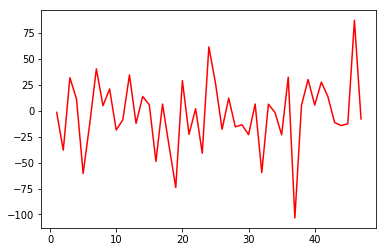

In [7]:
plot(chart['daily_return'], c='r')

# Moving Averages

## Simple Moving Average (SMA)

A simple moving average over $n$ periods, and weights in each period with equal weight.

(0, 0.2)

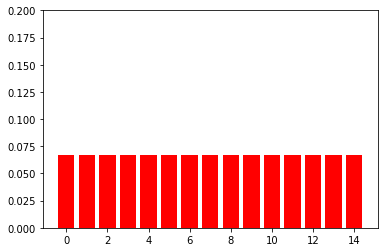

In [8]:
x, y = range(15), [1/15]*15
bar(x, y, facecolor='r')
axes = plt.gca()
axes.set_ylim(0,0.2)

In [9]:
def sma(df, periods = 7, source_column = 'close', target_column = 'sma'):
    df['{}{}'.format(target_column, periods)] = df[source_column].rolling(window=periods).mean()

In [10]:
sma(chart)

In [11]:
chart.head()

,close,date,high,low,open,daily_return,sma7
0,9431.641721,2018-04-30 01:00:00,9432.934620,9390.000000,9402.720313,NaN,NaN
1,9430.000000,2018-04-30 01:15:00,9431.512595,9390.117883,9431.512595,-1.641721,NaN
2,9392.022381,2018-04-30 01:30:00,9430.067142,9390.000000,9430.000000,-37.977619,NaN
3,9423.799996,2018-04-30 01:45:00,9429.534159,9392.022381,9392.022381,31.777616,NaN
4,9435.000000,2018-04-30 02:00:00,9436.738865,9409.000000,9423.799996,11.200004,NaN


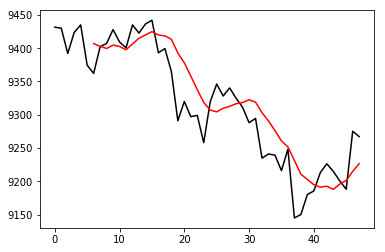

In [12]:
plot(chart['close'], c='black')
plot(chart['sma7'], c='r')

## Weighted Moving Average (WMA)

Moving average where the weight of later periods is linearly decreasing.

In [13]:
def triangular(n): return n * (n + 1) / 2

(0, 0.2)

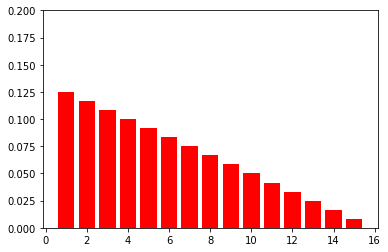

In [14]:
n = 15
x = np.linspace(1, n, n)
y = (n-x+1) / triangular(n)
bar(x, y, facecolor='r')
axes = plt.gca()
axes.set_ylim(0,0.2)

In [15]:
from scipy.ndimage.interpolation import shift
from pandas import Series

In [16]:
def wma(df, periods = 7, source_column = 'close', target_column = 'wma'):
    x = np.linspace(1, periods, periods)
    weights = (periods-x+1) / triangular(periods)
    wma = np.convolve(weights, df[source_column], 'valid')
    wma.resize(len(wma)+periods-1)
    wma = Series(wma)
    wma = wma.shift(periods-1)
    df['{}{}'.format(target_column, periods)] = wma  

In [17]:
wma(chart)

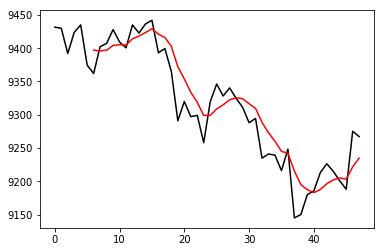

In [18]:
plot(chart['close'], c='black')
plot(chart['wma7'], c='r')

## Exponential Moving Average (EMA)

Moving average where the weight of later periods is exponentially decreasing.

(0, 0.2)

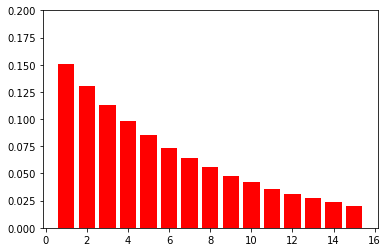

In [52]:
weights = np.exp(1-linspace(-1,1,n))
weights /= weights.sum()
bar(x, weights, facecolor='r')
axes = plt.gca()
axes.set_ylim(0,0.2)

In [49]:
sum(weights)

1.0000000000000002

In [20]:
from scipy.ndimage.interpolation import shift
from pandas import Series

In [21]:
def ema(df, periods = 7, source_column = 'close', target_column = 'ema'):
    weights = np.exp(1-np.linspace(-1, 1, periods))
    weights /= weights.sum()
    ema = np.convolve(weights, df[source_column], 'valid')
    ema.resize(len(ema)+periods-1)
    ema = Series(ema)
    ema = ema.shift(periods-1)
    df['{}{}'.format(target_column, periods)] = ema 

In [22]:
ema(chart)

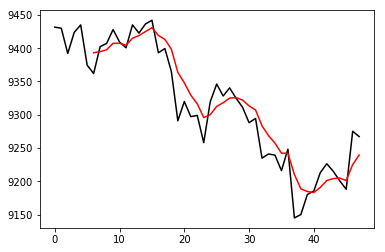

In [23]:
plot(chart['close'], c='black')
plot(chart['ema7'], c='r')

## Comparison

Comparison between the SMA, WMA and EMA.

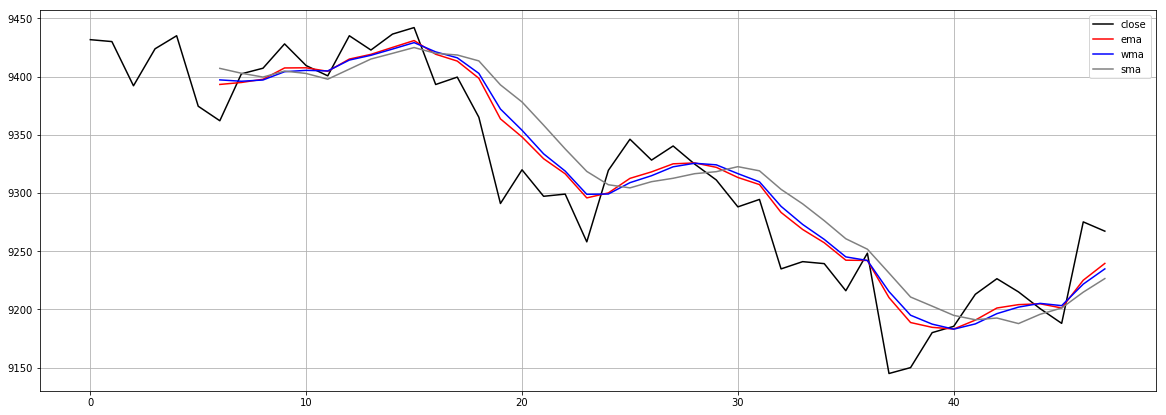

In [24]:
ema(chart)
plt.figure(figsize=(20,7))
plot(chart['close'], c='black')
plot(chart['ema7'], c='r')
plot(chart['wma7'], c='b')
plot(chart['sma7'], c='gray')
legend(['close', 'ema', 'wma', 'sma'])
grid();

# Standard deviation

Simple moving standard deviation which is used to calculate the Bollinger bands.

In [25]:
def std(df, periods = 20, source_column = 'close', target_column = 'std'):
    df['{}{}'.format(target_column, periods)] = df[source_column].rolling(window=periods).std()

In [26]:
std(chart)

In [27]:
chart.head()

,close,date,high,low,open,daily_return,sma7,wma7,ema7,std20
0,9431.641721,2018-04-30 01:00:00,9432.934620,9390.000000,9402.720313,NaN,NaN,NaN,NaN,NaN
1,9430.000000,2018-04-30 01:15:00,9431.512595,9390.117883,9431.512595,-1.641721,NaN,NaN,NaN,NaN
2,9392.022381,2018-04-30 01:30:00,9430.067142,9390.000000,9430.000000,-37.977619,NaN,NaN,NaN,NaN
3,9423.799996,2018-04-30 01:45:00,9429.534159,9392.022381,9392.022381,31.777616,NaN,NaN,NaN,NaN
4,9435.000000,2018-04-30 02:00:00,9436.738865,9409.000000,9423.799996,11.200004,NaN,NaN,NaN,NaN


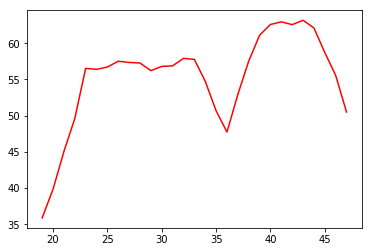

In [28]:
plot(chart['std20'], c='r')

# Bollinger Bands

Bollinger band is calculated as follows:

 * Standard deviation ($\sigma$) moving average for $n$ periods.
 * EMA for $n$ periods
 * The upper band is $\text{EMA} + 2\sigma$.
 * The lower band is $\text{EMA} - 2\sigma$.
 
The default period is $20$.

In [29]:
def bbands(df, periods = 20, source_column = 'close', target_column = 'bb'):
    temp_df = pd.DataFrame(df[source_column])
    std(temp_df, periods)
    ema(temp_df, periods)
    df['{}_mid'.format(target_column)] = temp_df['ema{}'.format(periods)]
    df['{}_upper'.format(target_column)] = temp_df['ema{}'.format(periods)] + 2*temp_df['std{}'.format(periods)]
    df['{}_lower'.format(target_column)] = temp_df['ema{}'.format(periods)] - 2*temp_df['std{}'.format(periods)]

In [30]:
bbands(chart)

In [31]:
chart.head()

,close,date,high,low,open,daily_return,sma7,wma7,ema7,std20,bb_mid,bb_upper,bb_lower
0,9431.641721,2018-04-30 01:00:00,9432.934620,9390.000000,9402.720313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9430.000000,2018-04-30 01:15:00,9431.512595,9390.117883,9431.512595,-1.641721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9392.022381,2018-04-30 01:30:00,9430.067142,9390.000000,9430.000000,-37.977619,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9423.799996,2018-04-30 01:45:00,9429.534159,9392.022381,9392.022381,31.777616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9435.000000,2018-04-30 02:00:00,9436.738865,9409.000000,9423.799996,11.200004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


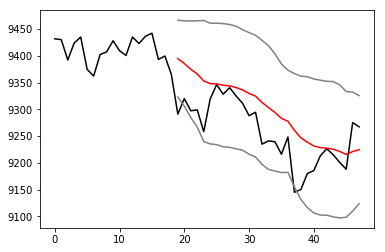

In [32]:
plot(chart['close'], c='black')
plot(chart['bb_mid'], c='r')
plot(chart['bb_upper'], c='gray')
plot(chart['bb_lower'], c='gray')

# Relative Strength Index (RSI)

The relative strength index is calculated with the following formula:

 * $\text{RSI}=100-100/(1+\text{RS})$
 * $\text{RS}=U / D$
 * $U$ is EMA of all positive moves in the last $n$ periods.
 * $D$ is EMA of (absolute values of) all negative moves in the last $n$ periods.
 * $n$ is the period of RSI.

In [53]:
def rsi(df, periods = 14, source_column='daily_return', target_column='rsi'):
    temp_df = pd.DataFrame(df[source_column])
    temp_df['closing_gains'] = temp_df[source_column].apply(lambda x: max(x, 0))
    temp_df['closing_losses'] = temp_df[source_column].apply(lambda x: abs(min(x, 0)))
    ema(temp_df, periods, 'closing_gains', 'closing_gains_ema')
    ema(temp_df, periods, 'closing_losses', 'closing_losses_ema')
    temp_df['rs'] = temp_df['closing_gains_ema{}'.format(periods)] / temp_df['closing_losses_ema{}'.format(periods)]
    df[target_column] = 100 - 100 / (1 + temp_df['rs'])

In [54]:
rsi(chart)

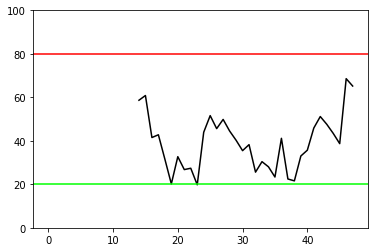

In [55]:
fig, ax = plt.subplots()
plot(chart['rsi'], c='black')
plt.axhline(y=80, c='r')
plt.axhline(y=20, c='lime')
ax.set_ylim(0, 100)
fill_between(list(chart.index), 20, 80, color='grey', alpha=0)

In [36]:
chart.head()

,close,date,high,low,open,daily_return,sma7,wma7,ema7,std20,bb_mid,bb_upper,bb_lower,rsi
0,9431.641721,2018-04-30 01:00:00,9432.934620,9390.000000,9402.720313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9430.000000,2018-04-30 01:15:00,9431.512595,9390.117883,9431.512595,-1.641721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9392.022381,2018-04-30 01:30:00,9430.067142,9390.000000,9430.000000,-37.977619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9423.799996,2018-04-30 01:45:00,9429.534159,9392.022381,9392.022381,31.777616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9435.000000,2018-04-30 02:00:00,9436.738865,9409.000000,9423.799996,11.200004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Parabolic SAR (stop and reverse)

tba.